<script src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS_HTML"></script>

In [ ]:
!git clone https://github.com/roeeSch/data_exercise.git

### Import necessary packages:

In [3]:
import numpy as np
import pandas as pd
import skimage.measure

from matplotlib import pyplot as plt

### Import local packages

In [4]:
all_data = True
analysis = False

from data_exercise.utils import ls2pc, ls2ft, calc_lin_char

### Load recording from csv file

In [5]:
# Load csv:
file_name, lookingUp = 'data_exercise/rec_11c.csv', False
table = pd.read_table(file_name, delimiter=',')

table.iloc[:3]

,Unnamed: 0,tick,stateEstimate.x,stateEstimate.y,stateEstimate.yaw,mr18.m0,mr18.m1,mr18.m2,mr18.m3,mr18.m4,...,mr18.m6,mr18.m7,mr18.m8,mr18.m9,mr18.m10,mr18.m11,mr18.m12,mr18.m13,mr18.m14,mr18.m15
0,0,0.0,-0.186084,0.164538,-0.712828,870.0,940.0,5001.0,1963.0,5002.0,...,772.0,570.0,5002.0,2024.0,5007.0,1199.0,1159.0,1200.0,1301.0,977.0
1,1,20.0,-0.184235,0.166270,-0.655830,853.0,919.0,5007.0,5002.0,5002.0,...,809.0,561.0,5002.0,5002.0,1136.0,1206.0,1182.0,1202.0,1296.0,973.0
2,2,33.0,-0.184358,0.166056,-0.650897,853.0,919.0,5007.0,5002.0,5002.0,...,809.0,561.0,5002.0,5002.0,1136.0,1206.0,1182.0,1202.0,1296.0,973.0


**Columns are:**
1. tick is the time column (in milliseconds)
2. stateEstimate.x and stateEstimate.y are the (x,y) coordinates of spot in meters.
3. stateEstimate.yaw is spots orientation in degrees.
4. The fields {mr18.m0, mr18.m1, ..., mr18.m15} are the range measurements in millimeters. Ranges above 4000 are measurement errors.


#### Convert recorded data into desired physical units:

In [6]:

time = table['tick'].to_numpy()
time -= time[0]
Ts = np.median(np.diff(time, 1))
print(f'original Ts={1000.0*Ts} [ms], time is [{time[0]},{time[-1]}]')

ranges = table[[f'mr18.m{i}' for i in range(16)]].to_numpy(dtype=float)*0.001
x = table['stateEstimate.x'].to_numpy()
y = table['stateEstimate.y'].to_numpy()

# unwrap angle:
t = np.unwrap(np.deg2rad(table['stateEstimate.yaw'].to_numpy()))
print(f'ranges shape before reduction: {ranges.shape}')

original Ts=11000.0 [ms], time is [0.0,248013.0]
ranges shape before reduction: (17577, 16)


#### Down-sample
If needed (computations are faster with less data), downsample the recording

In [7]:

# down-sample:
D = 1
if D>1:
    ranges = skimage.measure.block_reduce(ranges, (D,1), np.max)
    print(f'ranges shape after D=({D},1) reduction: {ranges.shape}')
    x = skimage.measure.block_reduce(x, (D,), np.median)
    y = skimage.measure.block_reduce(y, (D,), np.median)
    t = skimage.measure.block_reduce(t, (D,), np.median)
    time = skimage.measure.block_reduce(time, (D,), np.max)

Ts = np.median(np.diff(time, 1))
print(f'downsampled Ts={1000.0*Ts} [ms]')

downsampled Ts=11000.0 [ms]


#### Plot the x,y coordinates:

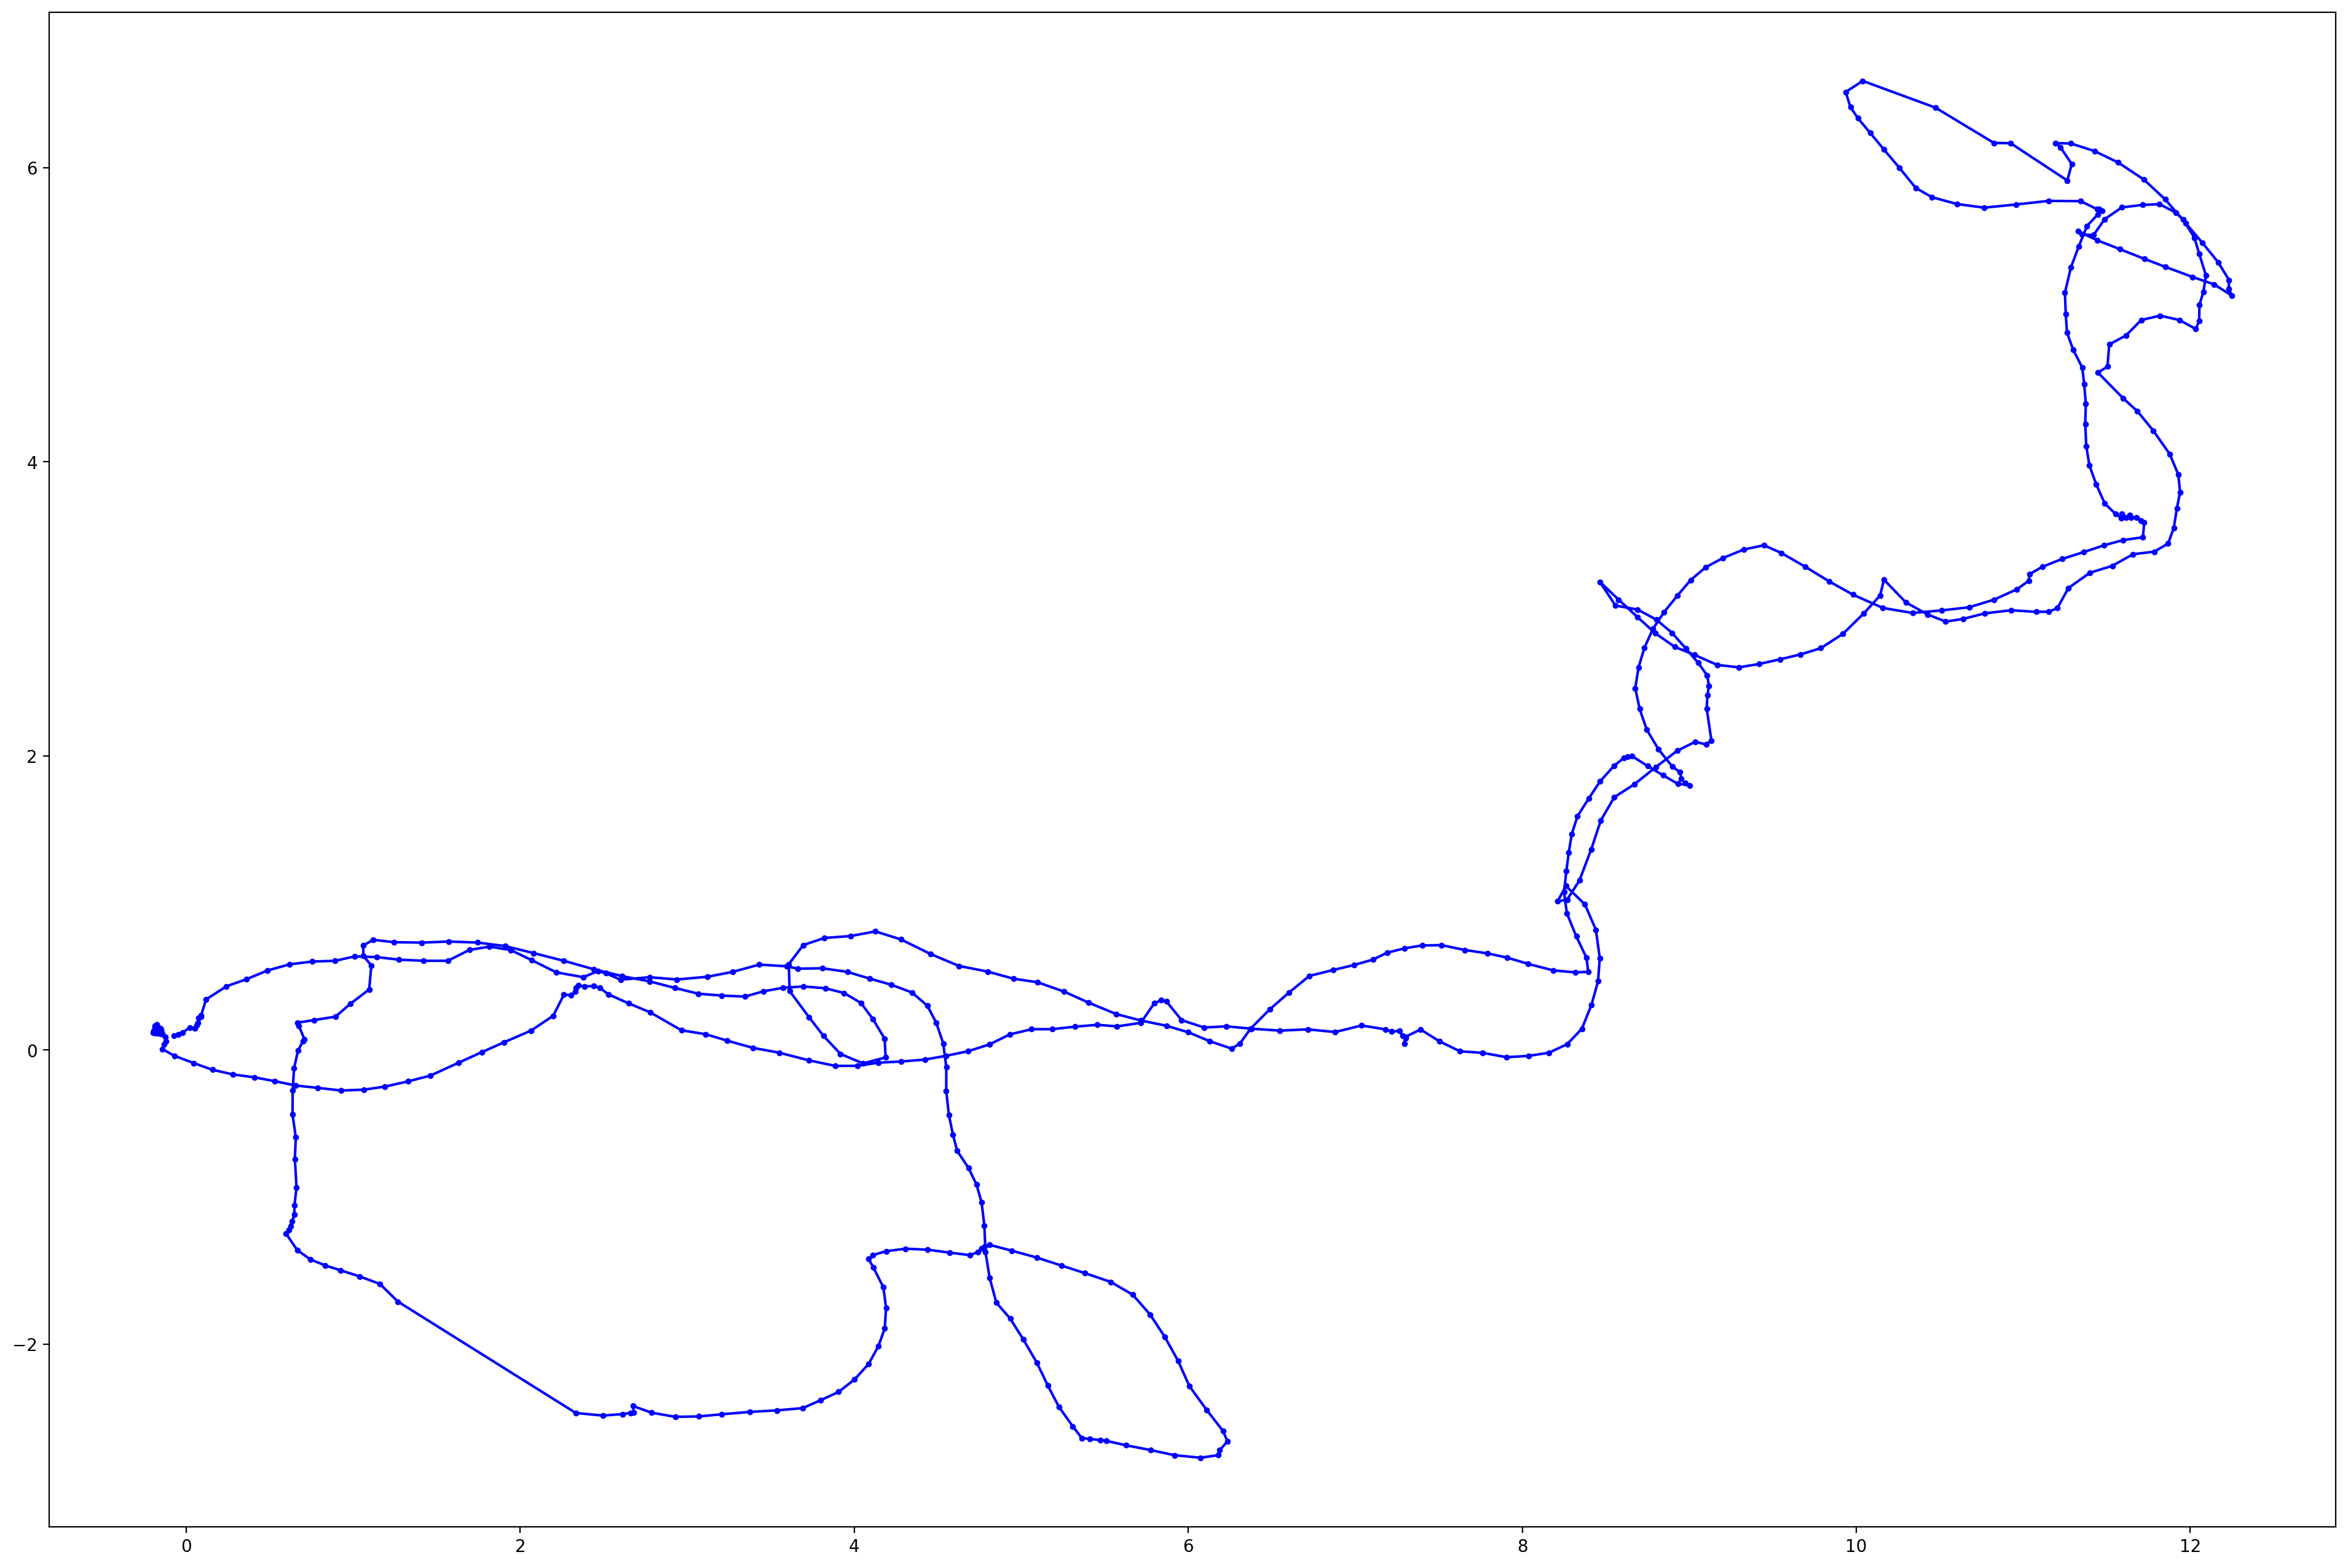

In [8]:
plt.figure(figsize=(24,16), dpi=200)
plt.plot(x[::31], y[::31], '-b.', markersize=5)
plt.show()

## Laser Scan Vs Point Cloud
*ls2pc* - converts ranges to their corresponding x,y coordinates


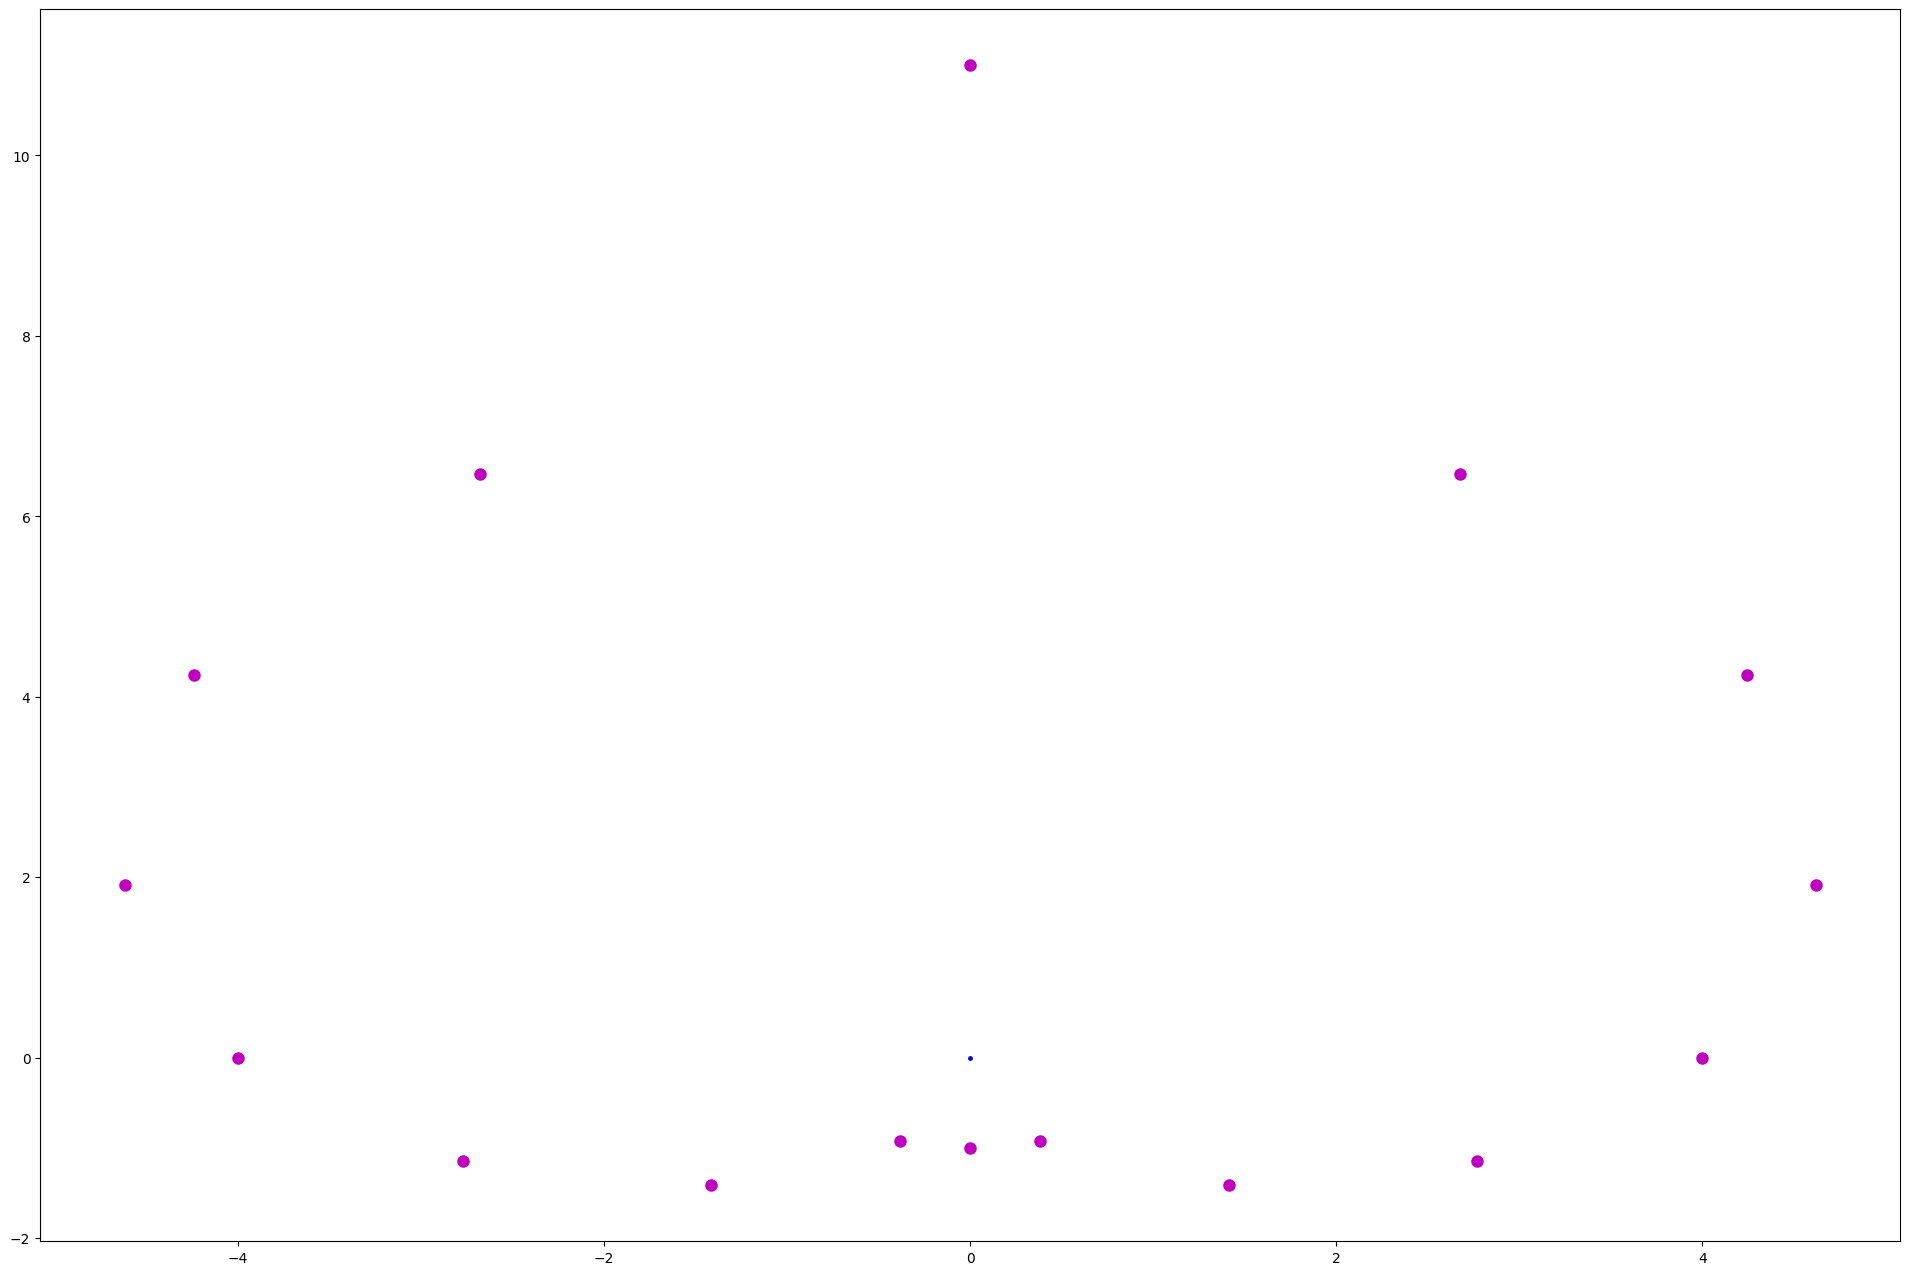

In [9]:
# This is a laser scan (LS) range array:
range_ = np.array([[1,1,2,3,4,5,6,7,11,7,6,5,4,3,2,1]])
# convert the LS to point cloud, using the information about the sensor orientations relative to each other:
x_origin = np.array([0])
y_origin = np.array([0])
yaw = np.array([0])

pc_x_r_, pc_y_r_, valid_inds_bool_, valid_inds_ = ls2pc(x_origin, y_origin, yaw, range_)

# plot the point cloud
plt.figure(figsize=(24,16), dpi=100)
plt.plot(pc_x_r_, pc_y_r_, 'm.', markersize=16)
plt.plot(0, 0, '-b.', markersize=5)
plt.show()

# play around with the other inputs of ls2pc: x_origin, y_origin, yaw.

## Add the laser scanner data


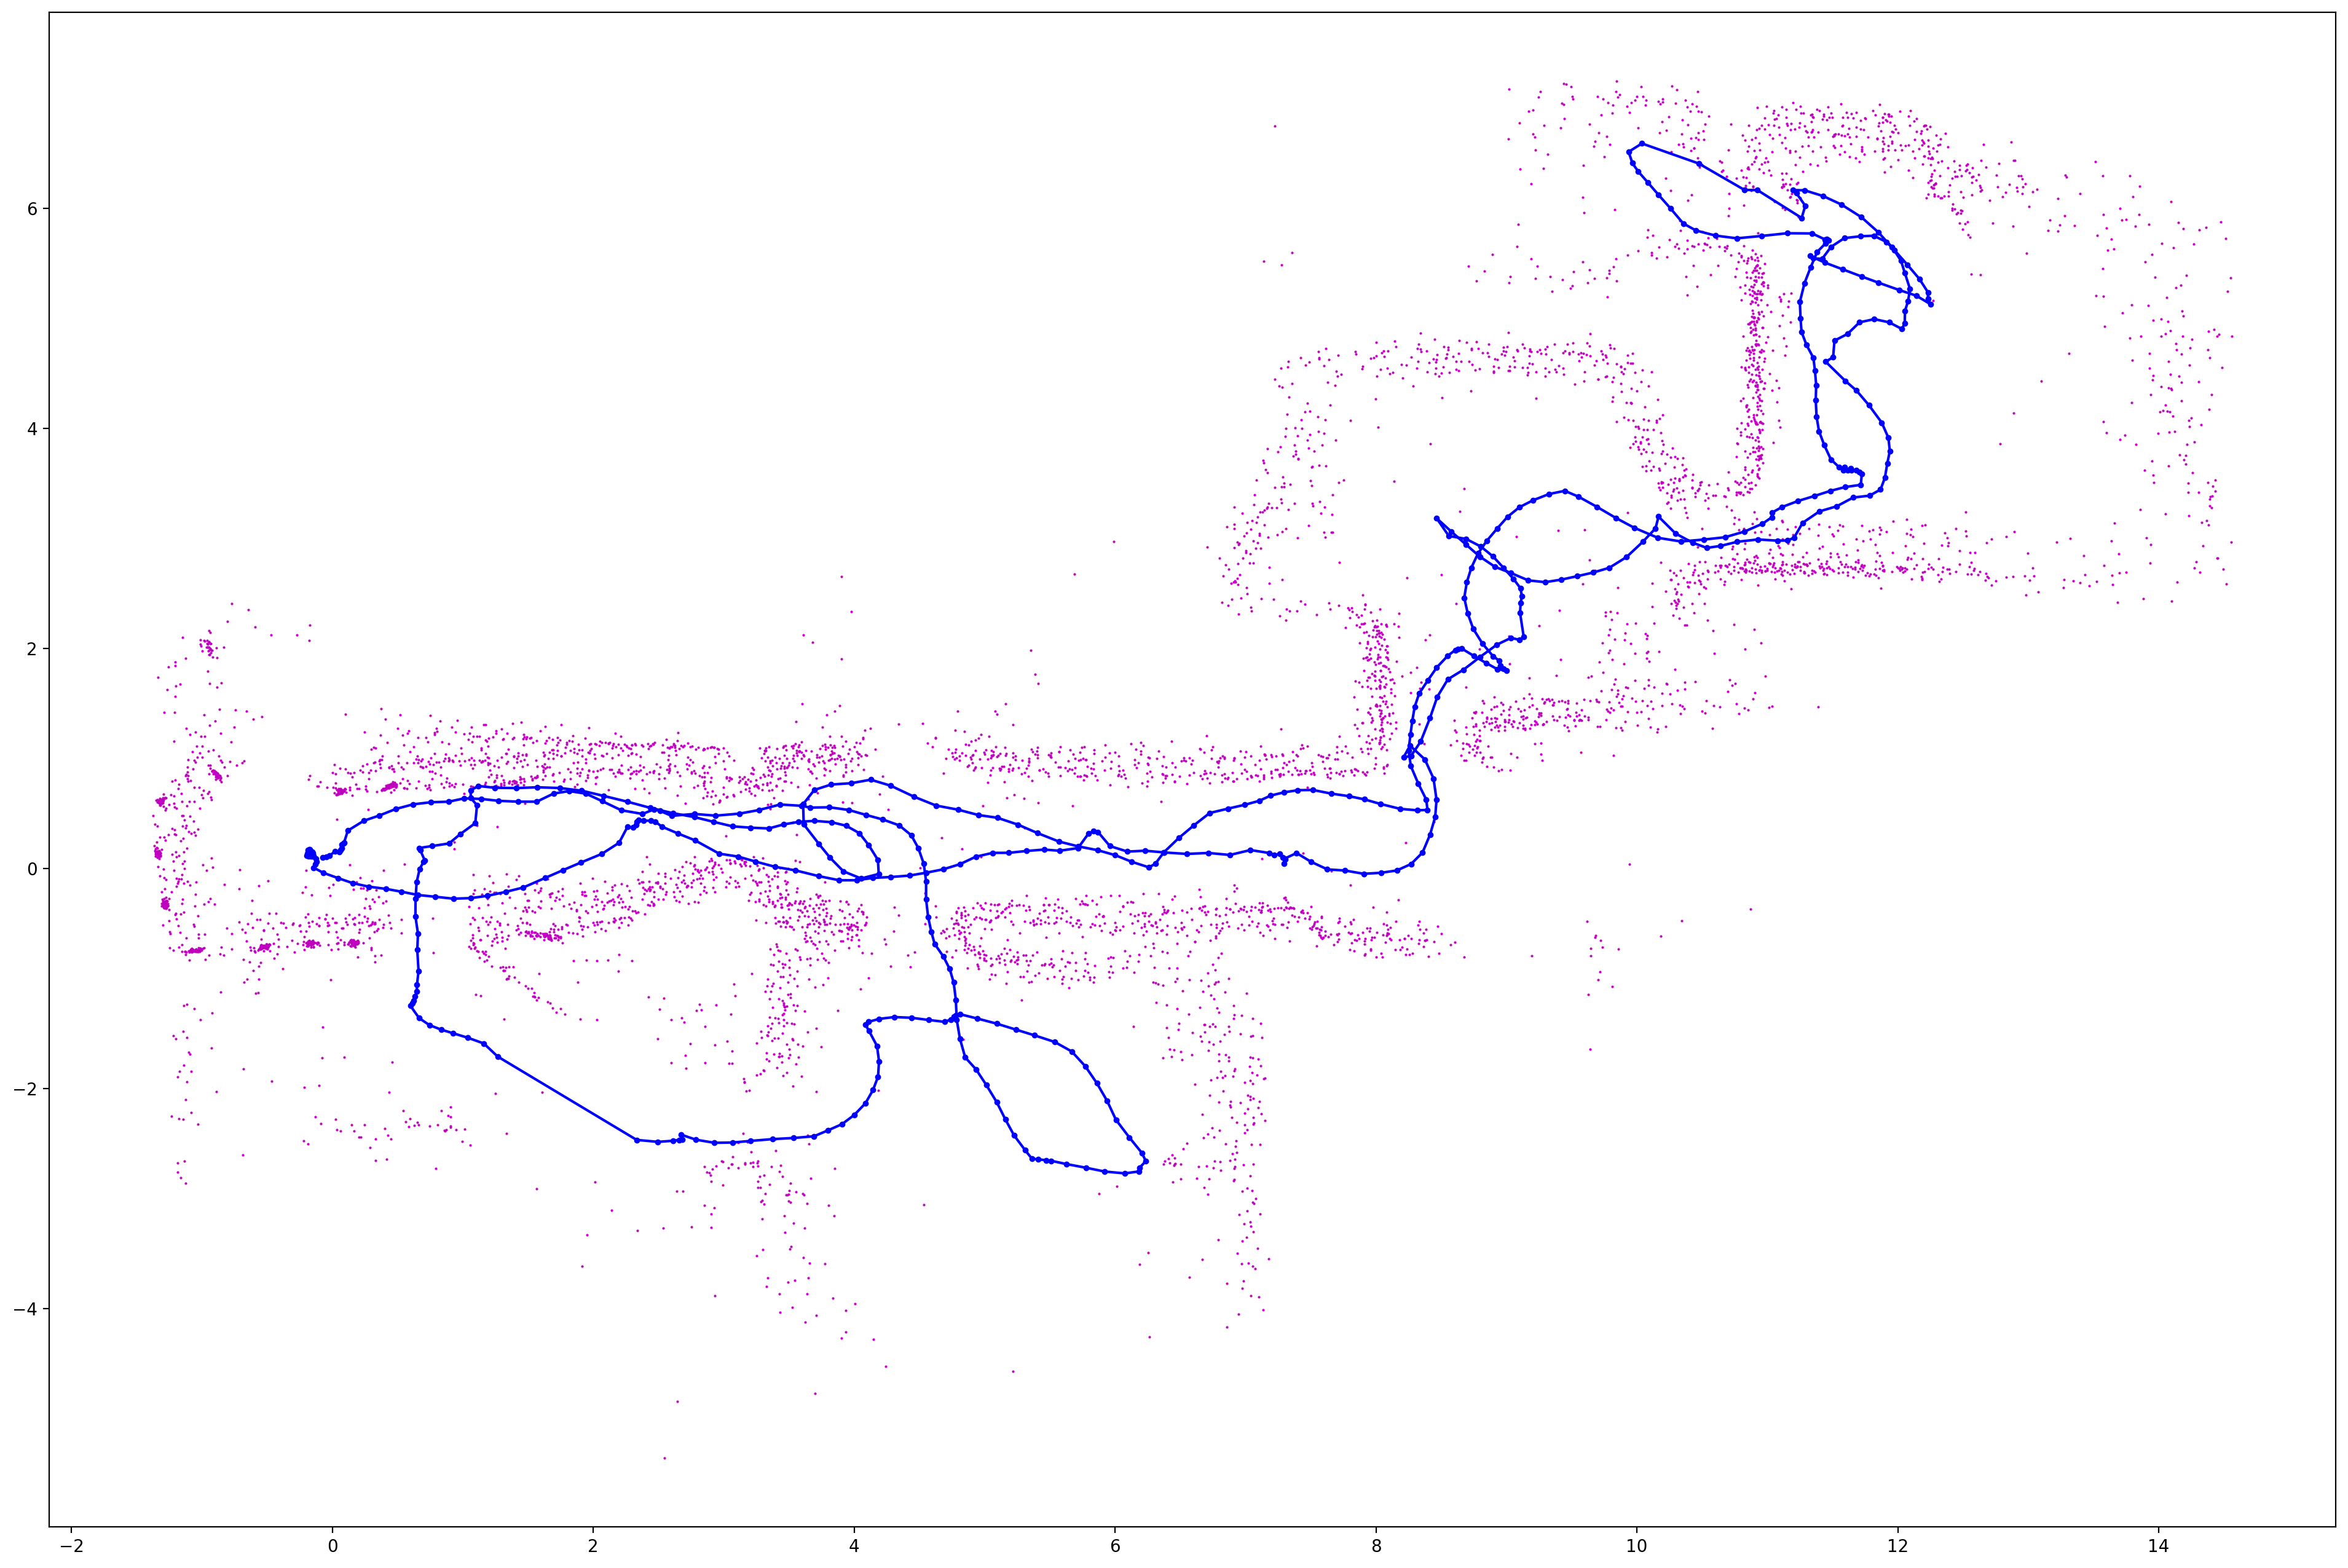

In [20]:
# Convert laser scan (16 ranges) to point cloud (2x16 xy coordinates)
pc_x_r_, pc_y_r_, valid_inds_bool_, valid_inds_ = ls2pc(x, y, t, ranges)
plt.figure(figsize=(24,16), dpi=200)
plt.plot(pc_x_r_[valid_inds_bool_][::31], pc_y_r_[valid_inds_bool_][::31], 'm.', markersize=1)
plt.plot(x[::31], y[::31], '-b.', markersize=5)
plt.show()

**What you see above is the same data ploted in the README.md**

In blue is the odometry - the xy coordinates of spot.

In magenta - the walls\objects picked up by the range sensors.

In [11]:
# convert laser scans to point cloud:
pc_x_r, pc_y_r, valid_inds_bool, valid_inds = ls2pc(x, y, t, ranges)

### Plot location with incrementally changing color:

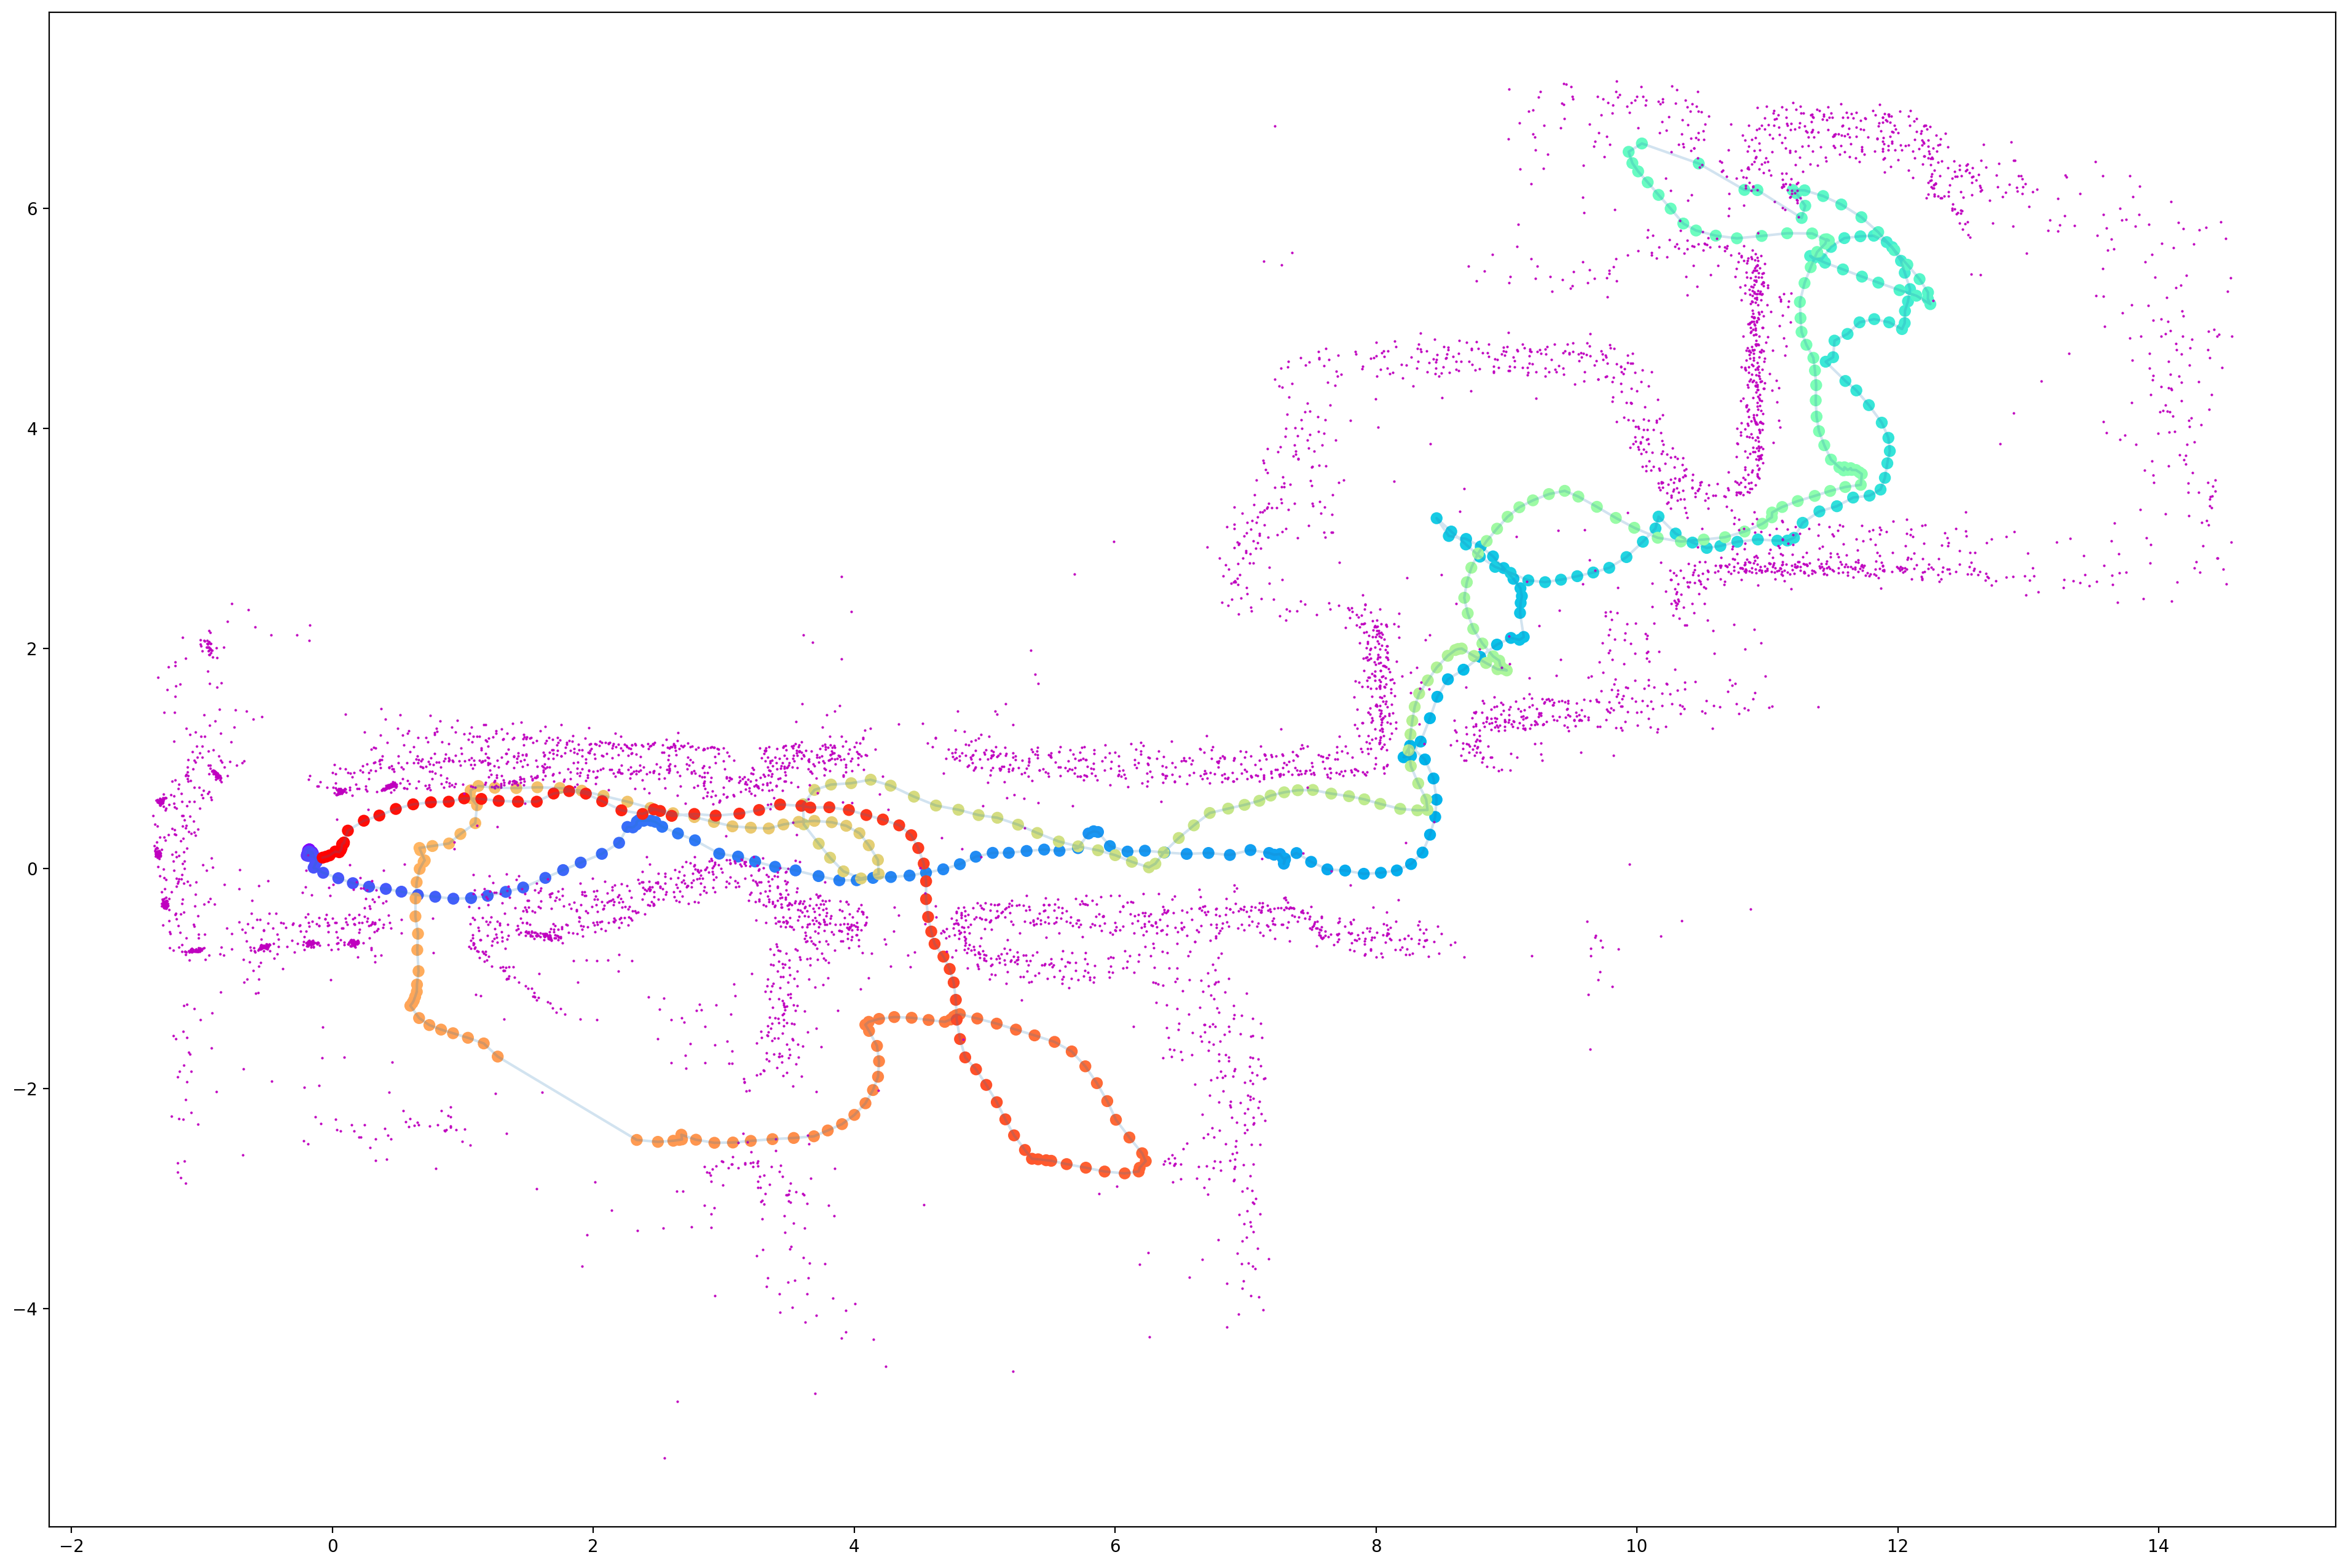

In [21]:
import matplotlib.cm as cm
c = cm.rainbow(np.linspace(0, 1, len(y[::31])))

plt.figure(figsize=(24,16), dpi=200)
plt.plot(pc_x_r_[valid_inds_bool_][::31], pc_y_r_[valid_inds_bool_][::31], 'm.', markersize=1)
plt.plot(x[::31], y[::31], alpha=0.2)
plt.scatter(x[::31], y[::31], color=c)
plt.show()

Note that the color of the location markers changes as a function of time (temporally close measurements closly colored)

### Task #1
1. Add 2 markers colored green and red. The green indicating the starting position and the red indicating the final.
2. Change the color of the odometry marker to visualize what percent of the 16 range measurements are above 2 meters. Use the color gradient 0%-black, 100%-blue.
    
  If $X_{x, y}^i$ is the location of spot at time $t_i$, and $\{r_n^i\}_{n=1}^{16}$ are the range measurements at time $t_i$, then the marker of $X_{x, y}^i$ will be colored as follows:

  $$f(\overline{r}~^i)=f(r_1^i,\ r_2^i,\ ...,\ r_{16}^i)=\sum_{n=1}^{16}\frac{1}{16}(r_n^i>2.0)$$
    
  $$Color(X_{x, y}^i)=\{R^i, G^i, B^i\} = \{0,\ 0,\ 255\cdot f(r_1^i,\ r_2^i,\ ...,\ r_{16}^i)\}$$

In [ ]:
# Enter your code here

### Task #2:
In your own words write a short explanation about what this feature ($f$) represents. If spot is in a location that is blue rather than black, what does this say about the surrounding?

### Task #3
What would you change in the above feature function $f$ so that it would be smoother and less descrete?

$|f^*(\overline{r}~^i)-f^*(\overline{r}~^{i-1})|~~<~~|f(\overline{r}~^i)-f(\overline{r}~^{i-1})|$

Add a plot with your suggestion and add a measure of smoothness that quanitfies how much smoother is your improved $f^*$ relative to $f$.

**Hint:** take a look at the **get_sigmoid** function in `utils.py`

### Summary:

In this preliminary notebook we learned:
1. What the data looks like (laser scan and odometry)
2. We learned how to display the data with matplotlib
3. Finally, in the tasks, we built a single feature that indicates a type of surrounding based on a laser scan.

In the next `ipynb` we will add more feature functions. These will be the bassis for bulding the required classifier mentioned in the *README.md*.

Now you should proceed to the main `ipynb`.